In [1]:
import pandas as pd
import matplotlib as plt
import requests
import io
from pyaxis import pyaxis
import urllib.request
import csv
import urllib3
import numpy as np
import re
import altair as alt
from vega_datasets import data
from pandas.api.types import CategoricalDtype
from plotnine import *
from plotnine.data import mpg
import emoji
import altair_viewer
from altair_saver import save
import ssl
import plotly.graph_objects as go

In [6]:
#Descargar archivos

def DownloadDatasets():
  
    d1="https://estadisticas.mecd.gob.es/EducaJaxiPx/files/_px/es/xlsx/Universitaria/Alumnado/EEU_2022/GradoCiclo/NuevoIngreso/l0/3_1_NI_Sex_Edad(1)_Rama_Univ.px"
    urllib.request.urlretrieve(d1, "Datos_1.xlsx")
    df_ds1=pd.read_excel('Datos_1.xlsx',header=[6,7],skiprows = range(1391, 1398))
    
    ssl._create_default_https_context = ssl._create_unverified_context
    d2="https://www.ine.es/jaxiT3/files/t/xlsx/24885.xlsx"
    urllib.request.urlretrieve(d2, "Datos_2.xlsx")
    df_ds2=pd.read_excel('Datos_2.xlsx',header=[6,7],skiprows = range(2136, 2180))
    return df_ds1,df_ds2

def cleandf(df):
    
    #Clean index
    df.iloc[:,0] = df.iloc[:,0].apply(lambda x: re.sub("^\s+|\s+$", "", x))
    df.drop(df[df.iloc[:,0] =="Todas las universidades"].index, inplace=True)
    df.drop(df[df.iloc[:,0] =="Total"].index, inplace=True)
    df.drop(df[df.iloc[:,0] =="Universidades Públicas"].index, inplace=True)
    df.drop(df[df.iloc[:,0] =="Universidades Públicas Presenciales"].index, inplace=True)
    df.drop(df[df.iloc[:,0] =="Universidades Públicas No Presenciales"].index, inplace=True)
    df.drop(df[df.iloc[:,0] =="Universidades Privadas"].index, inplace=True)
    df.drop(df[df.iloc[:,0] ==" Universidades Privadas Presenciales"].index, inplace=True)
    df.drop(df[df.iloc[:,0] =="Universidades Privadas No Presenciales"].index, inplace=True)
    
    #Separete by total
    Uidx=df[df.iloc[:,0]=="Ambos sexos"].index[0]
    Hidx=df[df.iloc[:,0]=="Hombres"].index[0]
    Midx=df[df.iloc[:,0]=="Mujeres"].index[0]
    ancla=df[df.iloc[:,0]=="De 18 a 21 años"].index
    
    dfU=df.truncate(before=Uidx+1, after=ancla[0]-1)
    dfH=df.truncate(before=Hidx+1, after=ancla[1]-1)
    dfM=df.truncate(before=Midx+1,after=ancla[2]-1)
    
    return  dfU,dfM,dfH

def Ex1Barplot(dfU):
    Alumnos=dfU[["Ciencias de la Salud","Ingeniería y Arquitectura","Ciencias"]].sum()
    dfBarChar=pd.DataFrame({'Alumnos':Alumnos})
    dfBarChar.reset_index(level=[0,1],inplace=True)
    dfBarChar.columns = ['Area', 'year', 'student']    
    
    #Data Transformation
    map_year={"2015-2016":"2015/16","2016-2017":"2016/17","2017-2018":"2017/18","2018-2019":"2018/19","2019-2020":"2019/20","2020-2021":"2020/21","2021-2022":"2021/22"}
    dfBarChar=dfBarChar.replace({"year": map_year})
    
    map_Area={"Ciencias de la Salud":"Salud","Ingeniería y Arquitectura":"Ingeniería/Arquitectura","Ciencias":"Ciencias"}
    dfBarChar=dfBarChar.replace({"Area": map_Area})
    
    #Numbers
    dfBarChar['student'] = dfBarChar['student'].apply(lambda x:round(x/1000, 2))
    
    #Plots
    dodge_text = position_dodge(width=1)                              # new
    ccolor = '#555555'

    barplotEx1=(ggplot(dfBarChar, aes(x='year', y='student', fill='Area'))
     +geom_col(stat='identity', position='dodge',show_legend=True)
     +geom_text(aes(label='student'),position=dodge_text,size=8, va='bottom')
     + theme(panel_background=element_rect(fill='white'),               # new
             axis_title_y=element_blank(),
             axis_line_x=element_line(color='black'),
             axis_line_y=element_blank(),
             axis_text_y=element_blank(),
             axis_text_x=element_text(color=ccolor,angle=45,weight='bold'),
             axis_ticks_major_y=element_blank(),
             panel_grid=element_blank(),
             panel_border=element_blank(),
             figure_size=(10, 6),
             aspect_ratio=1)
     + labs( x="Año Academico",
             title="Nuevas incorporaciones/año a grados cientifico/tecnico en España (10^3)")
    )
    
    print(barplotEx1)
    barplotEx1.save(filename = 'BarplotEx1.svg', width=15, height=10, dpi=1000)
    
    return dfBarChar

def Ex2Isotype(dfM,dfH,area):

    def pross(dfi,area,sexo):
        dfiSum=dfi[area].sum()
        d=pd.DataFrame({'Alumnos':dfiSum})
        d.reset_index(level=0,inplace=True)
        d.loc[:,"Sex"]=sexo
        d.columns = ['Year', 'Student', 'Sex']
        return d
    
    dfMclean=pross(dfM,area,"Women")
    dfHclean=pross(dfH,area,"Men")
    dfFinal=pd.concat([dfMclean,dfHclean])
    
    #Limpieza
    map_year={"2015-2016":"2015/16","2016-2017":"2016/17","2017-2018":"2017/18","2018-2019":"2018/19","2019-2020":"2019/20","2020-2021":"2020/21","2021-2022":"2021/22"}
    dfFinal=dfFinal.replace({"Year": map_year})
    dfFinal=dfFinal[dfFinal["Year"].isin(["2015/16","2021/22"])].reset_index(drop=True)
    dfFinal.loc[dfFinal['Year'] == "2015/16","Student"]=(dfFinal.loc[dfFinal['Year'] == "2015/16","Student"]*100)/dfFinal.loc[dfFinal['Year'] == "2015/16", 'Student'].sum()
    dfFinal.loc[dfFinal['Year'] == "2021/22","Student"]=(dfFinal.loc[dfFinal['Year'] == "2021/22","Student"]*100)/dfFinal.loc[dfFinal['Year'] == "2021/22", 'Student'].sum()
    dfFinal['StudentPerc']=dfFinal['Student'].apply(lambda x: round(x/10))
    dfFinal=dfFinal.loc[dfFinal.index.repeat(dfFinal.StudentPerc)].drop("StudentPerc",axis = 1)

    
    chart=alt.Chart(dfFinal).mark_text(size=45, baseline='middle').encode(
    alt.X('x:O',axis=alt.Axis(title='De cada 10 nuevos ingresados')),
    alt.Y('Sex:O',axis=None),
    alt.Row('Year:N', header=alt.Header(title='Estudiantes de ingenieria 2015 vs 2022')),
    alt.Text('emoji:N')
    ).transform_calculate(
        emoji="{'Women': '🧍‍♀️', 'Men': '🧍'}[datum.Sex]"
    ).transform_window(
        x='rank()',
        groupby=['Year', 'Sex']
    ).properties(width=550, height=140)
    
    return dfFinal,chart

def WaterFallEx3(df_ds2):
    df_ds2.iloc[:,0]=df_ds2.iloc[:,0].apply(lambda x:re.sub("\d+", "", x)).apply(lambda x: re.sub("^\s+|\s+$", "", x))
    idxGasol=df_ds2[df_ds2.iloc[:,0]=="Gasolina"].index[0]
    Gasolina=df_ds2.truncate(before=idxGasol+3, after=idxGasol+3)["Gasto medio por hogar"].transpose().reset_index()
    Gasolina.columns = ['Year', 'Spent']
    Gasolina=Gasolina.iloc[::-1].reset_index(drop=True)
    Gasolina['Spent_dif'] = Gasolina['Spent'].diff()
    Gasolina.loc[0,'Spent_dif']=Gasolina.loc[0,'Spent']
    Gasolina.loc[len(Gasolina)-1,'Spent_dif']=Gasolina.loc[len(Gasolina)-1,'Spent']
    Gasolina["Mesurements"]="relative"
    Gasolina.loc[len(Gasolina)-1,'Mesurements']="total"
    
    
    #plot
    fig = go.Figure(go.Waterfall(
    name = "20", orientation = "v",
    measure = Gasolina['Mesurements'].tolist(),
    x = Gasolina['Year'].tolist(),
    textposition = "outside",
    text = [round(item) for item in Gasolina['Spent_dif'].tolist()], 
    y = Gasolina['Spent_dif'].tolist(),
    connector = {"line":{"color":"rgb(63, 63, 63)"}},
    ))

    fig.update_layout(
            title = "Evolucion anual del gasto medio por hogar para la Gasolina",
            showlegend = False,
            title_x=0.5
    )
    fig.update_xaxes(minor=dict(showgrid=True),tickangle=45)
    fig.update_yaxes(minor=dict(showgrid=True))
    fig.write_image("WaterFallEx3.svg")

    fig.show()

    
    return Gasolina

C:\Users\agust\.conda\envs\Proyects\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default

C:\Users\agust\.conda\envs\Proyects\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default



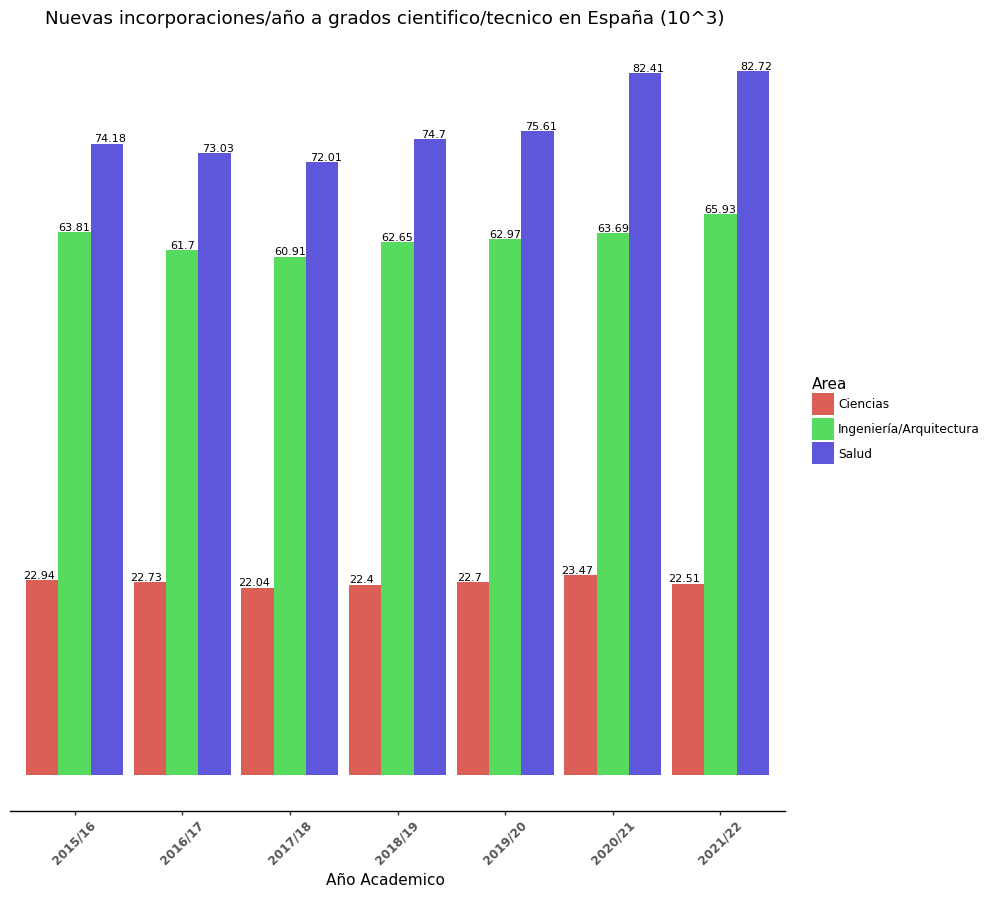

C:\Users\agust\.conda\envs\Proyects\lib\site-packages\plotnine\ggplot.py:718: PlotnineWarning:

Saving 15 x 10 in image.

C:\Users\agust\.conda\envs\Proyects\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning:

Filename: BarplotEx1.svg



alt.Chart(...)

In [8]:
#Carga de datos
df_ds1,df_ds2=DownloadDatasets()

#Primer Ejercicio
dfU,dfM,dfH=cleandf(df_ds1)
dfBarChar=Ex1Barplot(dfU)

#Tercera visualizacion
Gasolina=WaterFallEx3(df_ds2)

#Segunda Visualizacion
dfFinal,chart=Ex2Isotype(dfM,dfH,"Ingeniería y Arquitectura")
chart